In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import torch
from dataset import Asbest_segmentation
from tqdm import tqdm
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from utils import parse_anno_file, create_mask_file, big_image_predict, get_time, true_results

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
device = torch.device("cuda:" + str(torch.cuda.device_count() - 1) if torch.cuda.is_available() else "cpu")

asbest_model = smp.Unet(encoder_name='efficientnet-b3', in_channels=1, classes=2, activation='sigmoid').to(device)

asbest_model.load_state_dict(torch.load('asbest_segmentation.pth'))
asbest_model.eval();

100%|██████████| 134/134 [00:55<00:00,  2.43it/s]


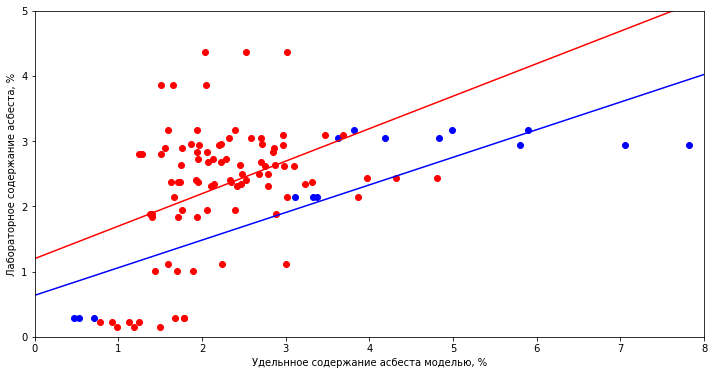

In [5]:
anno = parse_anno_file('asbest/tr_stones/annotation.xml')
manual_results = {'probes' : [], 'preds' : [], 'trues' : [], 'asbest' : [], 'stones' : []}
net_results = {'probes' : [], 'preds' : [], 'trues' : [], 'asbest' : [], 'stones' : []}

img_size = (448, 448)

for it in anno:
    name = it['name'].split('/')[-1]
    if get_time(name).day != 16:
        continue
    probe = int(name.split('_')[0])
    if probe < 10 or probe > 14:
        continue
    st_mask = create_mask_file(it, 'stone')
    asb_mask = create_mask_file(it, 'asbest')
    manual_results['probes'].append(probe)
    manual_results['preds'].append(100 * np.sum(asb_mask) / np.sum(st_mask))
    manual_results['asbest'].append(np.sum(asb_mask))
    manual_results['stones'].append(np.sum(st_mask))
    manual_results['trues'].append(true_results[16][probe])

for it in tqdm(anno, total=len(anno)):
    name = it['name'].split('/')[-1]
    if get_time(name).day != 16:
        continue
    probe = int(name.split('_')[0])
#     if probe < 10 or probe > 14:
#         continue
    img = cv2.imread(it['name'], cv2.IMREAD_UNCHANGED)
    _, _, asb_mask = big_image_predict(asbest_model, 
                                      img, 
                                      crop_size=(img.shape[0] // 2, img.shape[1] // 2),
                                      inp_size=img_size,
                                      device=device
                                     )
    st_mask = create_mask_file(it, 'stone', binary=True)
    asb_mask = asb_mask > 0.3
#     asb_mask = create_mask_file(it, 'asbest')
    net_results['probes'].append(probe)
    net_results['preds'].append(100 * np.sum(asb_mask) / np.sum(st_mask))
    net_results['asbest'].append(np.sum(asb_mask))
    net_results['stones'].append(np.sum(st_mask))
    net_results['trues'].append(true_results[16][probe])

p_manual = np.polyfit(manual_results['preds'], manual_results['trues'], 1)
reg_manual = np.polyval(p_manual, [0, 100])
    
p_net = np.polyfit(net_results['preds'], net_results['trues'], 1)
reg_net = np.polyval(p_net, [0, 100])

plt.figure(figsize=(12,6))
plt.scatter(manual_results['preds'], manual_results['trues'], c='b')
plt.plot([0, 100], reg_manual, 'b')

plt.scatter(net_results['preds'], net_results['trues'], c='r')
plt.plot([0, 100], reg_net, 'r')
plt.xlim(0, 8)
plt.ylim(0, 5)
plt.xlabel('Удельнное содержание асбеста моделью, %')
plt.ylabel('Лабораторное содержание асбеста, %')
# plt.figure(figsize=(20,10))
# plt.subplot(121)
# plt.imshow(st_mask)
# plt.subplot(122)
# plt.imshow(asb_mask)
plt.savefig('graphics/points_manual_and_model.png', dpi=100)

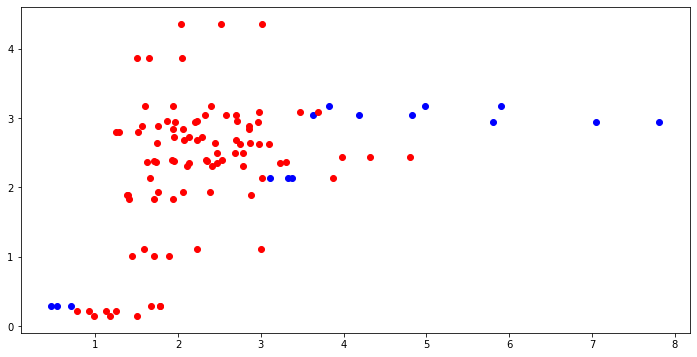

In [6]:
plt.figure(figsize=(12,6))
plt.scatter(manual_results['preds'], manual_results['trues'], c='b')
# plt.plot([min(manual_results['preds']), max(manual_results['preds'])], reg_manual, 'b')

plt.scatter(net_results['preds'], net_results['trues'], c='r')
# plt.plot([min(net_results['preds']), max(net_results['preds'])], reg_net, 'r')

asbest/tr_stones/11_11:59:43_16-03-2020_1.png
0.6645160319442915


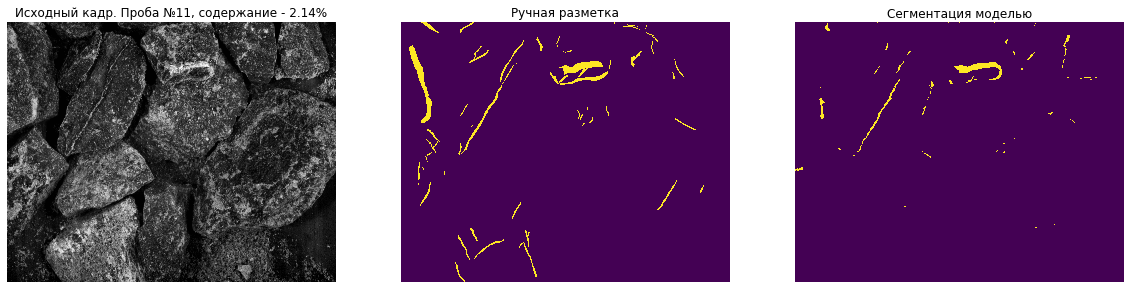

In [7]:
index = 6
print(anno[index]['name'])
img = cv2.imread(anno[index]['name'], cv2.IMREAD_UNCHANGED)
# img_shape = img.shape
img, st, asb = big_image_predict(asbest_model, 
                                  img, 
                                  crop_size=(img.shape[0] // 2, img.shape[1] // 2),
                                  inp_size=(448,448),
                                  device=device
                                 )
# st_mask = create_mask_file(anno[index], 'stone', binary=True)
asb_mask = create_mask_file(anno[index], 'asbest', binary=True)
plt.figure(figsize=(20,10));
plt.subplot(131)
plt.imshow(img, cmap=plt.cm.gray)
plt.axis('off')
plt.title('Исходный кадр. Проба №11, содержание - 2.14%')
plt.subplot(132)
plt.imshow(asb_mask)
plt.axis('off')
plt.title('Ручная разметка')
plt.subplot(133)
plt.imshow(asb > 0.5)
plt.axis('off')
plt.title('Сегментация моделью')
print(100 * np.sum(asb > 0.95) / np.sum(st_mask))


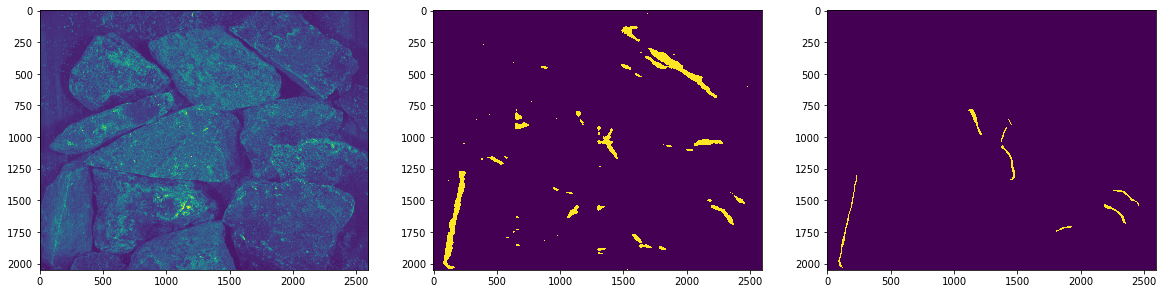

In [6]:

k = []
for it in anno:
    name = it['name'].split('/')[-1]
    if get_time(name).day != 16:
        continue
    probe = int(name.split('_')[0])
    if probe < 10 or probe > 14:
        continue
    img = cv2.imread(it['name'], cv2.IMREAD_UNCHANGED)
    _, _, asb_pred = big_image_predict(asbest_model, 
                                      img, 
                                      crop_size=(img.shape[0] // 2, img.shape[1] // 2),
                                      inp_size=img_size,
                                      device=device
                                     )
    asb_manual = create_mask_file(it, 'asbest')
    k.append(np.sum(asb_manual)  / np.sum(asb_pred))
    break
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(asb_pred > 0.5)
plt.subplot(133)
plt.imshow(asb_manual)

In [28]:
pd.DataFrame(net_results)


,probes,preds,trues,asbest,stones
0,10,0.003806,0.29,39837.238442,1046589615
1,10,0.003841,0.29,39837.238442,1037036805
2,10,0.003653,0.29,39837.238442,1090615365
3,11,0.003537,2.14,39837.238442,1126355400
4,11,0.003779,2.14,39837.238442,1054173060
...,...,...,...,...,...
86,8,0.003850,2.84,39837.238442,1034641590
87,8,0.003986,2.84,39837.238442,999344490
88,9,0.003543,2.37,39837.238442,1124259555
89,9,0.003663,2.37,39837.238442,1087411035
